## Method of Moment Estimation

**Functions**

`DataFrame.mean`, `DatFrame.sum`, `plt.subplots`, `plt.plot`, `stats.kurtosis`, `stats.skewness`

### Exercise 16
Estimate the mean, variance, skewness and kurtosis of the S&P 500 and Hang Seng using
the method of moments using monthly data.

In [1]:
# Read the data
import pandas as pd

monthly_hsi = pd.read_hdf("data/equity-indices.h5", "monthly_hsi")
monthly_sp500 = pd.read_hdf("data/equity-indices.h5", "monthly_sp500")

sp500 = 100 * monthly_sp500.Close.pct_change().dropna()
hsi = 100 * monthly_hsi.Close.pct_change().dropna()


In [2]:
hsi_mu = hsi.mean()
hsi_err = hsi - hsi_mu
hsi_var = (hsi_err**2).mean()
hsi_mom3 = (hsi_err**3).mean()
hsi_mom4 = (hsi_err**4).mean()
hsi_skew = hsi_mom3 / hsi_var ** (3/2)
hsi_kurt = hsi_mom4 / hsi_var ** (4/2)
hsi_stats = pd.Series([hsi_mu, hsi_var, hsi_skew, hsi_kurt],
                      index=["mean","var","skewness","kurtosis"])
hsi_stats

mean         0.874581
var         54.289172
skewness    -0.449607
kurtosis     7.759759
dtype: float64

In [3]:
sp500_mu = sp500.mean()
sp500_err = sp500 - sp500_mu
sp500_var = (sp500_err**2).mean()
sp500_mom3 = (sp500_err**3).mean()
sp500_mom4 = (sp500_err**4).mean()
sp500_skew = sp500_mom3 / sp500_var ** (3/2)
sp500_kurt = sp500_mom4 / sp500_var ** (4/2)
sp500_stats = pd.Series([sp500_mu, sp500_var, sp500_skew, sp500_kurt],
                      index=["mean","var","skewness","kurtosis"])
sp500_stats


mean         0.705218
var         16.893861
skewness    -0.432615
kurtosis     4.737685
dtype: float64

### Exercise 17
Estimate the asymptotic covariance of the mean and variance of the two series (separately,
but not the skewness and kurtosis). 

In [4]:
errors = pd.DataFrame({"mean": sp500_err, "var": sp500_err**2 - sp500_var},
                      index=sp500.index)
nobs = errors.shape[0]

sp500_acov = errors.T @ errors / nobs
sp500_acov

,mean,var
mean,16.893861,-30.039672
var,-30.039672,1066.744624


In [5]:
errors = pd.DataFrame({"mean": hsi_err, "var": hsi_err**2 - hsi_var},
                      index=hsi.index)
nobs = errors.shape[0]

hsi_acov = errors.T @ errors / nobs
hsi_acov


,mean,var
mean,54.289172,-179.846709
var,-179.846709,19923.134032


### Exercise 18
Estimate the Sharpe ratio of the two series and compute the asymptotic variance of
the Sharpe ratio. See Chapter 2 of the notes for more on this problem.


The asymptotic variance is computed as 

$$ D \Sigma D^\prime$$

where

$$ D = [\sigma^{-1}, -1/2 \mu \sigma^{-3} ] $$

and $\Sigma$ is the asymptotic covariance of the mean and variance. Finally, we
divide by $n$ the sample size when computing the statistic variance. 

In [6]:
import numpy as np

sr =  sp500_mu / np.sqrt(sp500_var)
print(f"The SR for the S&P 500 is {sr}")

d = np.array([[sp500_var** (-1/2), sp500_mu * -1/2 * sp500_var**(-3/2)]])
avar = np.squeeze(d @ sp500_acov @ d.T)

sr_var = avar / nobs
sr_std = np.sqrt(sr_var)
sr_tstat = sr / sr_std

pd.Series({"Sharpe Ratio": sr, "SR T-stat": sr_tstat})

The SR for the S&P 500 is 0.17157692389802914


Sharpe Ratio    0.171577
SR T-stat       3.240534
dtype: float64

In [7]:
sr =  hsi_mu / np.sqrt(hsi_var)
print(f"The SR for the Hang Seng is {sr}")

d = np.array([[hsi_var** (-1/2), hsi_mu * -1/2 * hsi_var**(-3/2)]])
avar = np.squeeze(d @ hsi_acov @ d.T)

sr_var = avar / nobs
sr_std = np.sqrt(sr_var)
sr_tstat = sr / sr_std

pd.Series({"Sharpe Ratio": sr, "SR T-stat": sr_tstat})

The SR for the Hang Seng is 0.11869795444582507


Sharpe Ratio    0.118698
SR T-stat       2.267232
dtype: float64


### Exercise 19
Plot rolling estimates of the four moments using 120 months of consecutive data using a
4 by 1 subplot against the dates.

The simple approach to this problem uses a loop accross 120, 121, ..., $n$ and computes
the statistics using 120 observations. The figure is then created with a call to `plt.subplots`
and the series can be directly plotted by calling `ax.plot`.

The pandas-centric approach uses teh `rolling` method to compute rolling statistics and
then uses `.plot.line` with `subplots=True` to produce the plot.

In [8]:
from scipy import stats
nobs = sp500.shape[0]
rolling_stats = np.zeros((nobs, 4))
for i in range(120, nobs):
    sample = sp500.iloc[i-120:i]
    mean = sample.mean()
    errors = sample - mean
    rolling_stats[i, 0] = 12 * mean
    var = (errors ** 2).mean()
    rolling_stats[i, 1] = np.sqrt(12) * np.sqrt(var)
    mom3 = (errors ** 3).mean()
    mom4 = (errors ** 4).mean()
    rolling_stats[i, 2] = mom3 / var ** (3/2)
    rolling_stats[i, 3] = mom4 / var ** (4/2)

rolling_stats[:120] = np.nan
rolling_stats = pd.DataFrame(rolling_stats,
                             columns=["Ann Mean", "Ann Std", "Skewness", "Kurtosis"],
                             index=sp500.index)

rolling_stats = rolling_stats.dropna()
rolling_stats.head()

,Ann Mean,Ann Std,Skewness,Kurtosis
Date,,,,
1960-02-29,12.608154,12.093508,-0.184724,2.457393
1960-03-31,12.600157,12.093569,-0.184149,2.457202
1960-04-30,12.420517,12.116337,-0.173050,2.437676
1960-05-31,11.857731,12.114036,-0.141598,2.430594
1960-06-30,11.669691,12.072906,-0.137613,2.452505


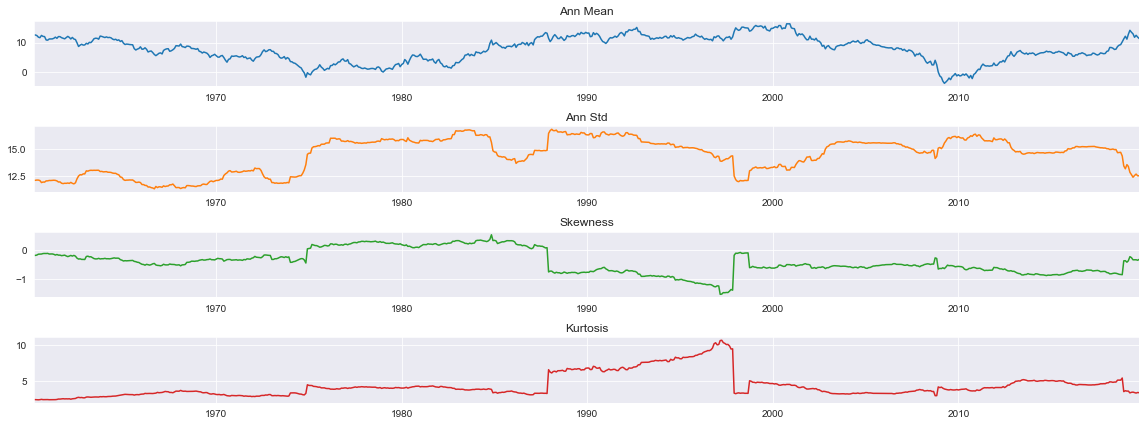

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16,6))
colors = sns.color_palette()

fig, ax = plt.subplots(4, 1)
dates = rolling_stats.index
xlim = (dates[0], dates[-1])

ax[0].plot(dates, rolling_stats["Ann Mean"], color=colors[0])
ax[0].set_title("Ann Mean")
ax[0].set_xlim(xlim)

ax[1].plot(dates, rolling_stats["Ann Std"], color=colors[1])
ax[1].set_title("Ann Std")
ax[1].set_xlim(xlim)

ax[2].plot(dates, rolling_stats["Skewness"], color=colors[2])
ax[2].set_title("Skewness")
ax[2].set_xlim(xlim)

ax[3].plot(dates, rolling_stats["Kurtosis"], color=colors[3])
ax[3].set_title("Kurtosis")
ax[3].set_xlim(xlim)
fig.tight_layout(pad=1.0)

In [10]:
roller = sp500.rolling(120)
rolling = pd.DataFrame({"Ann Mean": 12 * roller.mean(),
                        "Ann Std":np.sqrt(12 * roller.var()),
                        "Skewness": roller.apply(stats.skew, raw=False),
                        "Kurtosis": 3 + roller.apply(stats.kurtosis, raw=False)},
                       index=sp500.index)

rolling = rolling.dropna()
rolling

,Ann Mean,Ann Std,Skewness,Kurtosis
Date,,,,
1960-01-31,12.608154,12.144214,-0.184724,2.457393
1960-02-29,12.600157,12.144276,-0.184149,2.457202
1960-03-31,12.420517,12.167140,-0.173050,2.437676
1960-04-30,11.857731,12.164829,-0.141598,2.430594
1960-05-31,11.669691,12.123527,-0.137613,2.452505
...,...,...,...,...
2019-05-31,11.803063,12.590887,-0.335741,3.429378
2019-06-30,12.490406,12.724720,-0.336951,3.363716
2019-07-31,11.880270,12.561793,-0.353799,3.439682


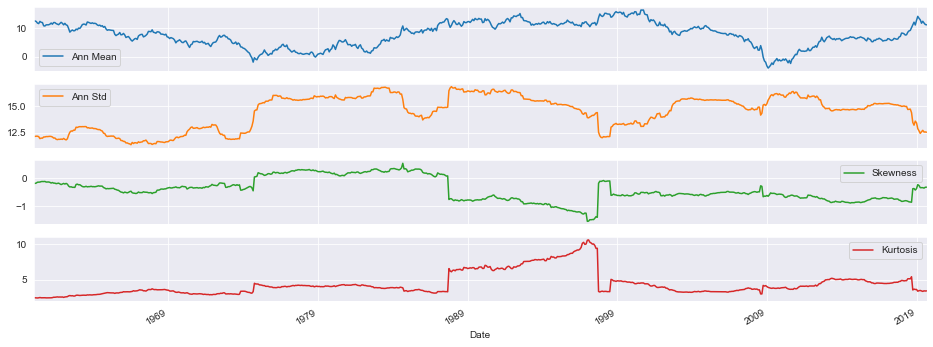

In [11]:
ax = rolling.plot.line(subplots=True)